<a href="https://colab.research.google.com/github/jackiekuen2/coursera-tensorflow/blob/master/Course_3_Week_3_Exercise_Kaggle_Sentiment_GloVe_Model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==2.0.0-rc

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc0


In [ ]:
import json
# import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"
#Your dataset size here. Experiment using smaller values (i.e. 160000), but don't forget to train on at least 160000 to see the best effects
training_size = 160000
test_portion = .1

corpus = []


In [ ]:

# Note that I cleaned the Stanford dataset to remove LATIN1 encoding to make it easier for Python CSV reader
# You can do that yourself with:
# iconv -f LATIN1 -t UTF8 training.1600000.processed.noemoticon.csv -o training_cleaned.csv
# I then hosted it on my site to make it easier to use in this notebook

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

num_sentences = 0

with open("/tmp/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    
    for row in reader:
      # Your Code here. Create list items where the first item is the text, found in row[5], and the second is the label. Note that the label is a '0' or a '4' in the text. When it's the former, make
      # your label to be 0, otherwise 1. Keep a count of the number of sentences in num_sentences
        list_item=[]
        list_item.append(row[5])
        this_label=row[0]
        if this_label=='0':
            list_item.append(0)
        else: 
            list_item.append(1)
        num_sentences = num_sentences + 1
        corpus.append(list_item)




--2019-09-03 04:38:30--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  77.0MB/s    in 3.0s    

2019-09-03 04:38:33 (77.0 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [ ]:
print(corpus[:5])
print(len(corpus))

[["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", 0], ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0], ['@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 0], ['my whole body feels itchy and like its on fire ', 0], ["@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ", 0]]
1600000


In [ ]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [ ]:
sentences=[]
labels=[]
random.shuffle(corpus)

for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(
    sequences,
    maxlen=max_length,
    truncating=trunc_type,
    padding=padding_type
)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
    
test_labels = np.array(labels[0:split])
training_labels = np.array(labels[split:training_size])

In [ ]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138022
1


In [ ]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2019-09-03 04:38:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   135MB/s    in 2.4s    

2019-09-03 04:38:52 (135 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138023


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # YOUR CODE HERE - experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
	tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13802300  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
bidirectional (Bidirectional (None, 3, 128)            66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [ ]:
num_epochs = 50

history = model.fit(
    training_sequences, 
    training_labels, 
    epochs=num_epochs, 
    validation_data=(test_sequences, test_labels), 
    verbose=1)

print("Training Complete")

Train on 144000 samples, validate on 16000 samples
Epoch 1/50


W0903 04:39:09.093684 140001155155840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


144000/144000 [==============================] - 145s 1ms/sample - loss: 0.5695 - accuracy: 0.6982 - val_loss: 0.5276 - val_accuracy: 0.7352
Epoch 2/50
144000/144000 [==============================] - 132s 917us/sample - loss: 0.5290 - accuracy: 0.7301 - val_loss: 0.5151 - val_accuracy: 0.7411
Epoch 3/50
144000/144000 [==============================] - 131s 913us/sample - loss: 0.5137 - accuracy: 0.7425 - val_loss: 0.5045 - val_accuracy: 0.7482
Epoch 4/50
144000/144000 [==============================] - 132s 914us/sample - loss: 0.5000 - accuracy: 0.7515 - val_loss: 0.5115 - val_accuracy: 0.7467
Epoch 5/50
144000/144000 [==============================] - 132s 914us/sample - loss: 0.4927 - accuracy: 0.7562 - val_loss: 0.5004 - val_accuracy: 0.7532
Epoch 6/50
144000/144000 [==============================] - 132s 916us/sample - loss: 0.4850 - accuracy: 0.7625 - val_loss: 0.4997 - val_accuracy: 0.7573
Epoch 7/50
144000/144000 [==============================] - 132s 918us/sample - loss: 0.4

<Figure size 432x288 with 0 Axes>

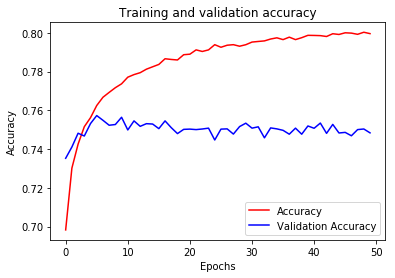

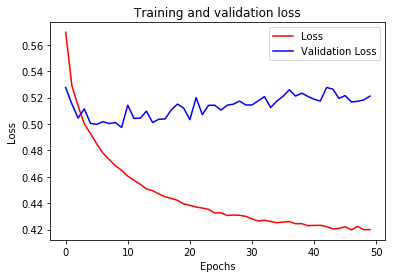

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!